## Загрузим нужные библиотеки

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier

%matplotlib inline

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.1f}'.format
pd.set_option('display.max_columns', None)

/Users/is_macbook/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
df_train = pd.read_csv("content/train_dataset_train.csv") # обучающий датасет
df_sample_solution = pd.read_csv("content/sample_solution.csv") # 

df_named = pd.read_csv("content/named.csv", infer_datetime_format=True) #
df_type_contract = pd.read_csv("content/type_contract.csv") #
df_log = pd.read_csv("content/log.csv", infer_datetime_format=True) #

## Рассмотрим датасет по ближе

In [4]:
df_train.head(3)

,contract_id,blocked
0,7780,0
1,7785,0
2,7794,0


<AxesSubplot:xlabel='blocked'>

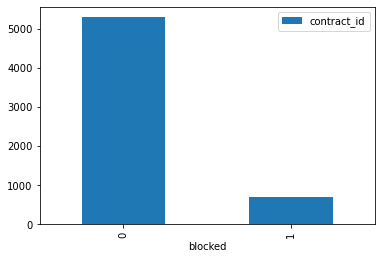

In [5]:
res_df_train = df_train.groupby('blocked').agg('count')
res_df_train.plot.bar()

In [6]:
res_df_train

,contract_id
blocked,
0,5294
1,698


Доля ушедших клиентов составляет 11,6%

In [7]:
df_named.head(3)

,date,url,contract_id
0,17-Apr-2021,webmail.sampo.ru,101397
1,17-Apr-2021,webmail.sampo.ru,179624
2,17-Apr-2021,tvip-provision.sampo.ru,190335


In [8]:
# изменение формата даты
df_named.date = pd.to_datetime(df_named.date, infer_datetime_format=True)

In [9]:
df_named.head(3)

,date,url,contract_id
0,2021-04-17,webmail.sampo.ru,101397
1,2021-04-17,webmail.sampo.ru,179624
2,2021-04-17,tvip-provision.sampo.ru,190335


<AxesSubplot:xlabel='date'>

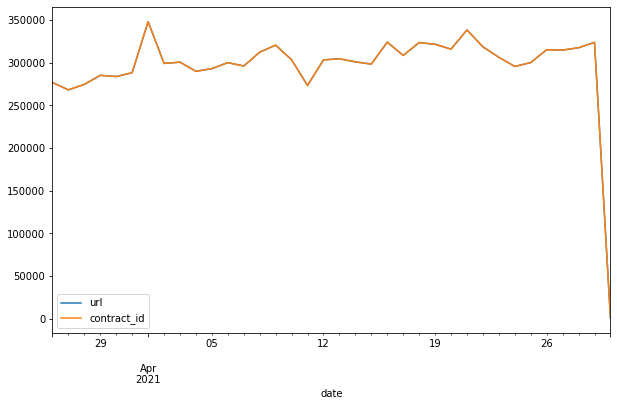

In [10]:
df_named.groupby('date').count().plot(figsize=(10,6))

За последний день апреля 2021 года в датасете значительно меньше данных, чем за прочие дни

In [11]:
df_named.groupby('url')['contract_id'].count().nlargest(15)

url
camera.rt.ru                    7333195
vmxott.svc.iptv.rt.ru            289876
tvip-provision.sampo.ru          138944
webmail.sampo.ru                 132718
statserv.sampo.ru                110428
193755.16.rt.ru                  106464
_sip._udp.193755.16.rt.ru        104596
_sip._tcp.193755.16.rt.ru        101820
530237.16.rt.ru                   99694
048056.16.rt.ru                   98511
_sip._udp.048056.16.rt.ru         98047
st44-broadcast.sampo.ru           74756
fe-nw.svc.iptv.rt.ru              68216
navigator.sampo.ru                64993
sz-ptzv-itv02.svc.iptv.rt.ru      63270
Name: contract_id, dtype: int64

In [12]:
# добавляю фичу с сокращенным доменом
df_named['dest'] = df_named['url'].str.extract('(rt.ru)').fillna('sampo.ru')

In [136]:
df_named.head(1)

,date,url,contract_id,dest
0,2021-04-17,webmail.sampo.ru,101397,sampo.ru


In [13]:
df_type_contract.head(3)

,contract_id,day_or_month_contract
0,7780,0
1,3996,0
2,7785,0


<AxesSubplot:xlabel='day_or_month_contract'>

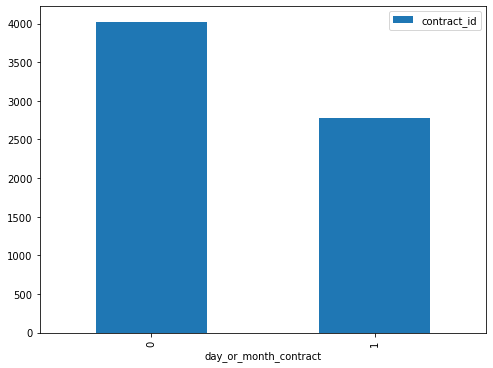

In [14]:
df_type_contract.groupby('day_or_month_contract').count().plot.bar(figsize=(8,6))

Аудитория клиентов с помесячной тарификацией превышает аудиторию с подневным тарифом 

In [15]:
df_log.head(3)

,contract_id,event_date,event_type
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета


<AxesSubplot:ylabel='event_type'>

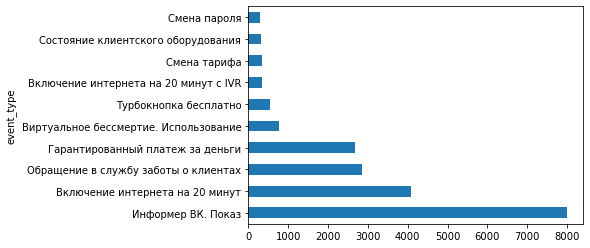

In [16]:
# обзор самых популярных обращений
df_log.groupby(['event_type'])['contract_id'].count().nlargest(10).plot.barh()

In [17]:
# добавление фичи, которая маркирует популярные обращения свыше 1000

pop_log_list = ['Информер ВК. Показ', 'Включение интернета на 20 минут',
                'Обращение в службу заботы о клиентах', 'Гарантированный платеж за деньги']

def mark_pop_log(n):
    if n in pop_log_list:
        return 1
    else:
        return 0
    
df_log['popular_log'] = df_log.apply(lambda x: mark_pop_log(x.event_type), axis=1)

In [18]:
# убираю время из даты обращения
df_log['event_date'] = pd.to_datetime(df_log.event_date, format='%Y-%m-%d').dt.date

In [19]:
df_log.event_date = pd.to_datetime(df_log.event_date, infer_datetime_format=True)

In [20]:
df_log.head(3)

,contract_id,event_date,event_type,popular_log
0,36294,2021-03-28,Добавление в Обращались с номеров,0
1,36294,2021-03-28,Обращение в службу заботы о клиентах,1
2,36294,2021-03-28,Выключение IPTV-пакета,0


Узнаем размерность наборов

In [21]:
print("df_train", df_train.shape)
print("df_named", df_named.shape)
print("df_sample_solution", df_sample_solution.shape)
print("df_type_contract", df_type_contract.shape)
print("df_log", df_log.shape)

df_train (5992, 2)
df_named (10646537, 4)
df_sample_solution (810, 2)
df_type_contract (6805, 2)
df_log (25274, 4)


In [22]:
df_type_contract.contract_id.nunique()

6800

В датасете df_type_contract содержится больше записей, чем в обучающем датасете. Предполагаю, что остальные записи хранятся в тестовом датасете

In [23]:
# обзор тестового датасета
df_sample_solution.head(5)

,contract_id,blocked
0,3453,0
1,3454,0
2,3455,0
3,3456,0
4,3457,0


<AxesSubplot:>

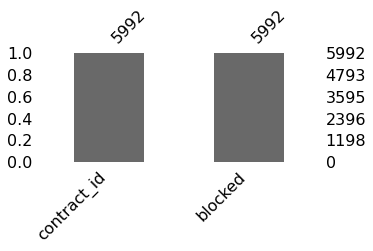

In [24]:
# обзор пропущенных значений
msno.bar(df_train, figsize=(5,2))

<AxesSubplot:>

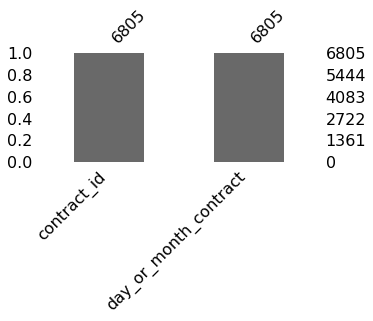

In [25]:
msno.bar(df_type_contract, figsize=(5,2))

<AxesSubplot:>

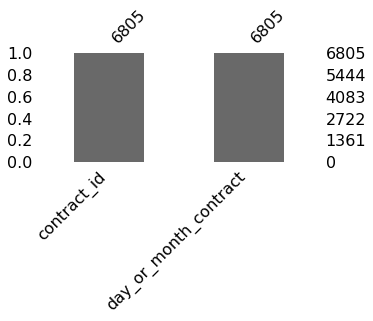

In [26]:
msno.bar(df_type_contract, figsize=(5,2))

<AxesSubplot:>

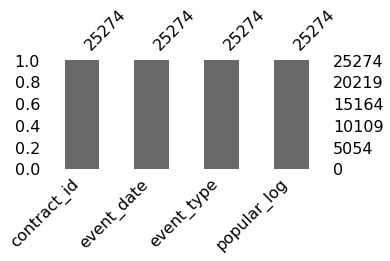

In [27]:
msno.bar(df_log, figsize=(5,2))

В датасетах нет пропущенных данных

### Видоизмение данных

Обьединим два набора с данными

In [28]:
# объединение 
train = pd.merge(df_train, df_type_contract , on="contract_id", how='left').drop_duplicates(subset="contract_id").fillna(0)

# возврат столбца к формату int
train.day_or_month_contract = train.day_or_month_contract.astype(int)

train.head(3)

,contract_id,blocked,day_or_month_contract
0,7780,0,0
1,7785,0,0
2,7794,0,0


Добавим столбец - колличество обращений человека

In [29]:
count_log = df_log.groupby("contract_id").count()

count_log.head(3)

,event_date,event_type,popular_log
contract_id,,,
3453,1,1,1
3454,1,1,1
3456,4,4,4


<AxesSubplot:>

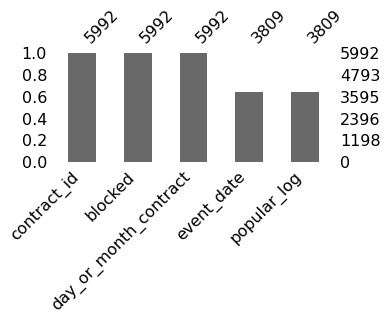

In [30]:
train = pd.merge(train, count_log , on="contract_id", how='left').drop(["event_type"],axis =1)

# график пропущенных значений
msno.bar(train, figsize=(5,2))

Заменим пропуски на нули и переименуем колонку

In [31]:
train = train.fillna(0)
train.rename(columns={"event_date": "event_count"}, inplace=True)

In [32]:
named_transform = pd.get_dummies(df_named[['contract_id', 'dest']]).groupby(['contract_id']).sum()
#= pd.get_dummies(df_named.dest)
named_transform.head(5)

,dest_rt.ru,dest_sampo.ru
contract_id,,
3455,5.0,19.0
3458,1.0,0.0
3459,1.0,1.0
3460,0.0,10.0
3461,1.0,0.0


In [33]:
named_transform.shape

(196148, 2)

In [34]:
named_transform = named_transform.drop_duplicates(keep='first')

<AxesSubplot:>

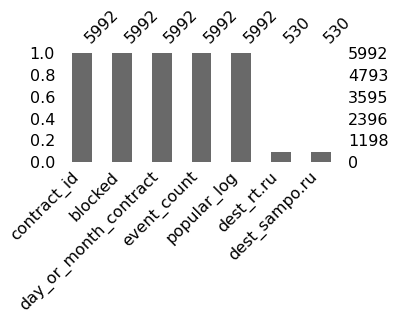

In [35]:
train = pd.merge(train, named_transform , on="contract_id", how='left')

# график пропущенных значений
msno.bar(train, figsize=(5,2))

<AxesSubplot:>

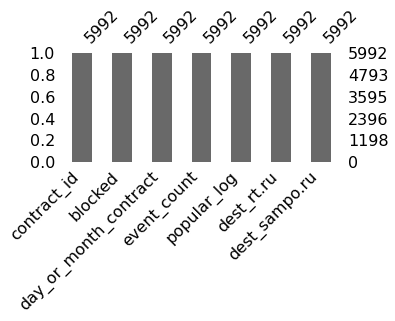

In [36]:
train.fillna(0, inplace=True)
msno.bar(train, figsize=(5,2))

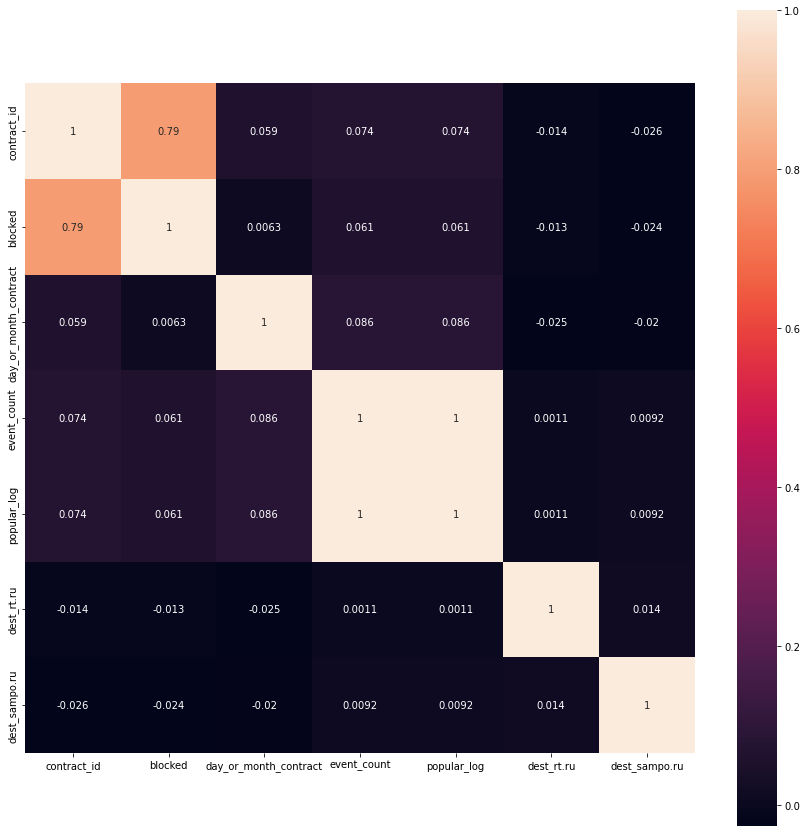

In [37]:
plt.rcParams['figure.figsize']=(15,15)

corr = train.corr()
g = sns.heatmap(corr, square = True, annot=True)

Рассмотрим корреляцию по ушедшим клиентам

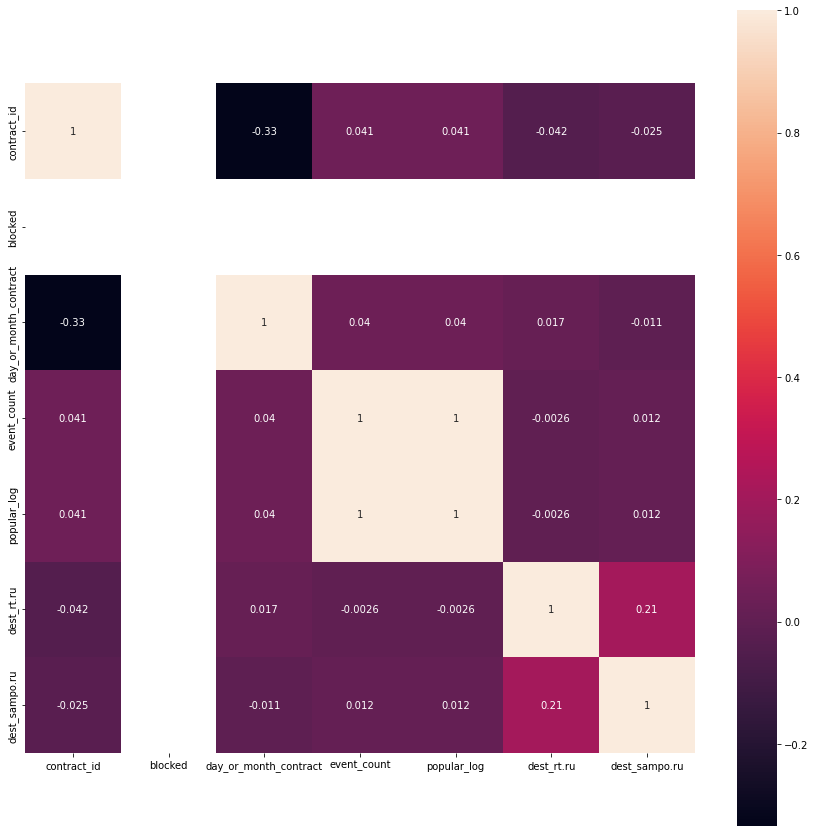

In [160]:
plt.rcParams['figure.figsize']=(15,15)

corr = train[train.blocked==1].corr()
g = sns.heatmap(corr, square = True, annot=True)

Наиболее явные признаки коррелирующие с переходом клиента к другому провайдеру содержатся в столбцах с количеством обращений клиентов, в тч обзор популярных обращений и переходы в домен конкурентов

## Выделим выборки

In [39]:
X = train.drop(['contract_id', "blocked"], axis = 1)
y = train[["blocked"]]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Обучение модели

RandomForestClassifier

In [42]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

XGBClassifier

In [43]:
xgb = XGBClassifier(eta=0.01,
                   eval_metric='auc', 
                   verbosity=2).fit(X_train, y_train,
                         eval_set=[(X_test, y_test)])

[19:48:38] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.60266
[19:48:38] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.60266
[19:48:38] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.60266
[19:48:38] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.60266


[19:48:38] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[33]	validation_0-auc:0.60265
[19:48:38] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[34]	validation_0-auc:0.60265
[19:48:38] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[35]	validation_0-auc:0.60265
[19:48:38] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[36]	validation_0-auc:0.60

[19:48:38] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[66]	validation_0-auc:0.59654
[19:48:38] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[67]	validation_0-auc:0.59654
[19:48:38] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[68]	validation_0-auc:0.59654
[19:48:38] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[69]	validation_0-auc:0.59

[19:48:38] INFO: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[99]	validation_0-auc:0.60104


In [300]:
pool_full_train = Pool(data=train.drop(["blocked"], axis = 1),
                      label=train[["blocked"]])


CatBoostClassifier

In [44]:
cbc = CatBoostClassifier(#iterations=1000,
                         learning_rate=0.01, 
                         #depth=8,
                         loss_function='CrossEntropy',
                         eval_metric='Recall')

cbc.fit(X_train, y_train,
        eval_set=(X_test, y_test),
        verbose=100,
        use_best_model=True,
        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 63.1ms	remaining: 1m 3s
100:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 234ms	remaining: 2.08s
200:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 396ms	remaining: 1.57s
300:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 559ms	remaining: 1.3s
400:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 718ms	remaining: 1.07s
500:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 879ms	remaining: 876ms
600:	learn: 0.0082474	test: 0.0000000	best: 0.0000000 (0)	total: 1.05s	remaining: 700ms
700:	learn: 0.0103093	test: 0.0000000	best: 0.0000000 (0)	total: 1.25s	remaining: 536ms
800:	learn: 0.0123711	test: 0.0000000	best: 0.0000000 (0)	total: 1.42s	remaining: 353ms
900:	learn: 0.0123711	test: 0.0000000	best: 0.0000000 (0)	total: 1.59s	remaining: 175ms
999:	learn: 0.0144330	test: 0.0000000	best: 0.0000000 (0)	total: 1.75s	remaining: 0us

bestTest = 0
bestIteration = 0

Shr

In [322]:
cbc.get_params()

{'learning_rate': 0.01,
 'loss_function': 'CrossEntropy',
 'eval_metric': 'Recall'}

In [321]:
# проверка обученности модели
cbc.is_fitted()

True

## Оценка точности

In [45]:
pred = clf.predict(X_test)
pred

array([0, 0, 0, ..., 0, 0, 0])

In [46]:
pred_cbc = cbc.predict(X_test)
pred_cbc

array([0, 0, 0, ..., 0, 0, 0])

In [47]:
pred_xgb = xgb.predict(X_test)
pred_xgb

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
print("Recall score:", recall_score(y_test, pred, average='macro'))

Recall score: 0.49873817034700313


In [49]:
print("Recall score:", recall_score(y_test, pred_cbc, average='macro'))

Recall score: 0.5


In [50]:
print("Recall score:", recall_score(y_test, pred_xgb, average='macro'))

Recall score: 0.5


# Предсказание на тестовом наборе

In [312]:
# объединение 
test = pd.merge(df_sample_solution, df_type_contract , on="contract_id", how='left').drop_duplicates(subset="contract_id").fillna(0)

# возврат столбца к формату int
test.day_or_month_contract = test.day_or_month_contract.astype(int)

test = pd.merge(test, count_log , on="contract_id", how='left').drop(["event_type"],axis =1)


test.rename(columns={"event_date": "event_count"}, inplace=True)

named_transform = pd.get_dummies(df_named[['contract_id', 'dest']]).groupby(['contract_id']).sum()

test = pd.merge(test, named_transform , on="contract_id", how='left')
#= pd.get_dummies(df_named.dest)
test = test.fillna(0)
test = test.astype(int)

In [313]:
test

,contract_id,blocked,day_or_month_contract,event_count,popular_log,dest_rt.ru,dest_sampo.ru
0,3453,0,0,1,1,0,0
1,3454,0,1,1,1,0,0
2,3455,0,1,0,0,5,19
3,3456,0,0,4,4,0,0
4,3457,0,0,4,4,0,0
...,...,...,...,...,...,...,...
805,4258,0,1,3,3,0,0
806,4259,0,1,0,0,8,476
807,4260,0,0,3,3,0,9
808,4261,0,0,18,18,0,0


In [325]:
pool_test_solution = Pool(data=test.drop(["blocked"], axis = 1),
                      )

In [329]:
test.drop(["blocked"], axis = 1)

,contract_id,day_or_month_contract,event_count,popular_log,dest_rt.ru,dest_sampo.ru
0,3453,0,1,1,0,0
1,3454,1,1,1,0,0
2,3455,1,0,0,5,19
3,3456,0,4,4,0,0
4,3457,0,4,4,0,0
...,...,...,...,...,...,...
805,4258,1,3,3,0,0
806,4259,1,0,0,8,476
807,4260,0,3,3,0,9
808,4261,0,18,18,0,0


In [330]:
cbc_test = cbc.predict(test.drop(["blocked"], axis = 1))

In [336]:
pred_clf = clf.predict(test.drop(["blocked"], axis = 1))
pred_clf

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [337]:
pred_xgb2 = xgb.predict(test.drop(["blocked"], axis = 1))
pred_xgb2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [335]:
solution_data = pd.DataFrame(test.contract_id)
solution_data['blocked'] = pd.Series(cbc_test)
solution_data

,contract_id,blocked
0,3453,0
1,3454,0
2,3455,0
3,3456,0
4,3457,0
...,...,...
805,4258,0
806,4259,0
807,4260,0
808,4261,0


Применение оверсемплирования в целях балансировки классов и повышения качества оценки модели

In [163]:
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import StandardScaler

x2 = train.drop(['contract_id','blocked'], axis=1)
y2 = train.blocked

# выполню стандартизацию для сглаживания данных
x2 = StandardScaler().fit_transform(x2)

# SMOTE
X_resampled_s, y_resampled_s = SMOTE().fit_resample(x2, y2)

# ADASYN
X_resampled_a, y_resampled_a = ADASYN().fit_resample(x2, y2)

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled_a, y_resampled_a, test_size=0.3, random_state=47)

In [165]:
cbc = CatBoostClassifier(iterations=2000,
                         learning_rate=0.008, 
                         depth=10,
                         #eta=0.002,
                         loss_function='Logloss'#'Logloss'#,CrossEntropy
                         ,custom_metric=['Logloss',
                                          'AUC:hints=skip_train~false', 'F1']
                         ,eval_metric='Recall'
                         ,auto_class_weights='Balanced'
                         #,use_best_model=True
                        )

cbc.fit(X_train, y_train,
        eval_set=(X_test, y_test),
        verbose=100,
        use_best_model=True,
        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7483770	test: 0.7206875	best: 0.7206875 (0)	total: 10.9ms	remaining: 21.8s
100:	learn: 0.7512334	test: 0.7231430	best: 0.7243708 (5)	total: 755ms	remaining: 14.2s
200:	learn: 0.7533108	test: 0.7262124	best: 0.7262124 (195)	total: 1.59s	remaining: 14.2s
300:	learn: 0.7559076	test: 0.7274401	best: 0.7274401 (207)	total: 2.32s	remaining: 13.1s
400:	learn: 0.7595430	test: 0.7292818	best: 0.7298956 (383)	total: 3.04s	remaining: 12.1s
500:	learn: 0.7629187	test: 0.7305095	best: 0.7305095 (482)	total: 3.75s	remaining: 11.2s
600:	learn: 0.7657751	test: 0.7323511	best: 0.7323511 (579)	total: 4.47s	remaining: 10.4s
700:	learn: 0.7652558	test: 0.7335789	best: 0.7335789 (644)	total: 5.19s	remaining: 9.63s
800:	learn: 0.7657751	test: 0.7341928	best: 0.7341928 (778)	total: 5.93s	remaining: 8.88s
900:	learn: 0.7662945	test: 0.7366483	best: 0.7366483 (898)	total: 6.63s	remaining: 8.09s
1000:	learn: 0.7670735	test: 0.7378760	best: 0.7378760 (1000)	total: 7.36s	remaining: 7.34s
1100:	learn: 

In [221]:
# оценка скора CatBoostClassifier

pred_cbc = cbc.predict(X_test)
pred_cbc
print("Recall score:", recall_score(y_test, pred_cbc, average='macro'))

Recall score: 0.9986174920575717


In [ ]:
clf = RandomForestClassifier(n_estimators=5000
                             ,max_depth=12
                             #,min_samples_split=6
                             #,min_samples_leaf=1
                             ,random_state=42
                             ,criterion='log_loss'
                            )
clf.fit(X_train, y_train)
predict = clf.predict(X_test)
print("Recall score:", recall_score(y_test, predict, average='macro'))

In [168]:
from sklearn.neighbors import KNeighborsClassifier

# инициация модели
knc = KNeighborsClassifier().fit(X_train, y_train)

# получение предсказанных результатов
knc_predict = knc.predict(X_test)
print("Recall score:", recall_score(y_test, knc_predict, average='macro'))

Recall score: 0.5699532629445416


У CatBoost скор значительно вырос, чем у RandomForestClassifier и KNeighborsClassifier. Но по итогу оценки с валидационными данными на сайте чемпионата скор был 0.50

# Обучение на обогащенном датасете

Гипотеза заключается в том, что полноту (Recall) можно повысить на тестовой выборке благодаря сбору датасета без очищения от дублей и с новыми фичами. 
<br><br>
На большем объеме данных модель может лучше найти взаимосвязи, также планирую оставить даты в наборе данных и применить модель CatBoostClassifier, которая может работать с категориальными признаками в необработанном виде.

In [248]:
df_namedd.head(1)

,date,url,contract_id,dest
0,2021-04-17,webmail.sampo.ru,101397,sampo.ru


In [251]:
# добавление новой фичи "кол-во переходов по всем ссылкам"

count_url = pd.DataFrame(df_named.groupby("contract_id")['url'].count())
count_url.rename(columns={'url': 'url_count'}, inplace=True)

count_url.head(3)

,url_count
contract_id,
3455,24
3458,1
3459,2


In [343]:
# сборка обучающего датасета
train_full = df_train.copy()
train_full = train_full.merge(df_log, on='contract_id')
train_full = train_full.merge(df_named, on='contract_id')
train_full = train_full.merge(df_type_contract, on='contract_id')
train_full = train_full.merge(count_log, on="contract_id")
named_transform = pd.get_dummies(df_named[['contract_id', 'dest']]).groupby(['contract_id']).sum()
train_full = train_full.merge(named_transform, on="contract_id")
train_full = train_full.merge(count_url, on="contract_id")
train_full['dest_rt.ru'] = train_full['dest_rt.ru'].astype(int)
train_full['dest_sampo.ru'] = train_full['dest_sampo.ru'].astype(int)
train_full.drop(['event_date_y', 'event_type_y'], axis=1, inplace=True)
train_full.rename(columns={'event_date_x': 'event_date', 'popular_log_x': 'popular_log',
                           'popular_log_y': 'event_count', 'event_type_x': 'event_type'}, inplace=True)


train_full

,contract_id,blocked,event_date,event_type,popular_log,popular_log_blocked,date,url,dest,day_or_month_contract,event_count,dest_rt.ru,dest_sampo.ru,url_count
0,7780,0,2021-03-17,Отключение услуги Автоплатёж,0,0,2021-04-29,start.sampo.ru,sampo.ru,0,9,0,83,83
1,7780,0,2021-03-17,Отключение услуги Автоплатёж,0,0,2021-04-29,profile.sampo.ru,sampo.ru,0,9,0,83,83
2,7780,0,2021-03-17,Отключение услуги Автоплатёж,0,0,2021-04-29,vhod.sampo.ru,sampo.ru,0,9,0,83,83
3,7780,0,2021-03-17,Отключение услуги Автоплатёж,0,0,2021-04-29,kino.sampo.ru,sampo.ru,0,9,0,83,83
4,7780,0,2021-03-17,Отключение услуги Автоплатёж,0,0,2021-04-29,lk.sampo.ru,sampo.ru,0,9,0,83,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569297,274786,1,2021-04-28,Обращение в службу заботы о клиентах,1,1,2021-04-05,fnc.rt.ru,rt.ru,1,9,1,0,1
569298,274786,1,2021-04-29,Обращение в службу заботы о клиентах,1,1,2021-04-05,fnc.rt.ru,rt.ru,1,9,1,0,1
569299,274786,1,2021-04-25,Включение интернета на 20 минут с IVR,0,1,2021-04-05,fnc.rt.ru,rt.ru,1,9,1,0,1
569300,274786,1,2021-04-26,Информер ВК. Показ,1,1,2021-04-05,fnc.rt.ru,rt.ru,1,9,1,0,1


Просмотр списка из 10 самых попрулярных событий у ушедших клиентов

In [185]:
train_full.query('blocked == 1').groupby('event_type')['contract_id'].count().nlargest(10)

event_type
Информер ВК. Показ                       7652
Обращение в службу заботы о клиентах     3111
Включение интернета на 20 минут          2800
Гарантированный платеж за деньги         1888
Включение интернета на 20 минут с IVR     678
Внутреннее сообщение                      555
Добавление в Обращались с номеров         489
Оборудование                              349
Активация ГП с IVR                        334
Отключение услуги Аренда ТВ-приставки     328
Name: contract_id, dtype: int64

In [517]:
# сбор списка значений для новой фичи
list_blocked_event = ['Информер ВК. Показ', 'Обращение в службу заботы о клиентах',
                     'Включение интернета на 20 минут', 'Гарантированный платеж за деньги',
                     'Включение интернета на 20 минут с IVR', 'Внутреннее сообщение',
                     'Добавление в Обращались с номеров', 'Оборудование', 'Активация ГП с IVR',
                     'Отключение услуги Аренда ТВ-приставки']

# так же выделю 4-ку самых крупных событий

list_most_blocked_event = ['Информер ВК. Показ', 'Обращение в службу заботы о клиентах',
                           'Включение интернета на 20 минут', 'Гарантированный платеж за деньги']

def new_feature(n, l):
    if n in l:
        return 1
    else:
        return 0
    
train_full['popular_log_blocked'] = train_full.apply(lambda x: new_feature(x.event_type, list_most_blocked_event)
                                                     , axis=1)
train_full['popular_more_log_blocked'] = train_full.apply(lambda x: new_feature(x.event_type, list_blocked_event)
                                                     , axis=1)

In [280]:
train_full.query('blocked==1').head(5)

,contract_id,blocked,event_date,event_type,popular_log,popular_log_blocked,date,url,dest,day_or_month_contract,event_count,dest_rt.ru,dest_sampo.ru,url_count,popular_url_blocked,popular_more_log_blocked
109950,10798,1,2021-04-07,Обращение в службу заботы о клиентах,1,1,2021-04-12,data.sampo.ru,sampo.ru,0,5,1,1,2,1,1
109951,10798,1,2021-04-07,Обращение в службу заботы о клиентах,1,1,2021-04-19,fnc.rt.ru,rt.ru,0,5,1,1,2,1,1
109952,10798,1,2021-04-07,Предложение тарифа,0,0,2021-04-12,data.sampo.ru,sampo.ru,0,5,1,1,2,0,0
109953,10798,1,2021-04-07,Предложение тарифа,0,0,2021-04-19,fnc.rt.ru,rt.ru,0,5,1,1,2,0,0
109954,10798,1,2021-04-24,Информер ВК. Показ,1,1,2021-04-12,data.sampo.ru,sampo.ru,0,5,1,1,2,1,1


Посмотрим на 10 популярных ссылок по каждому конкуренту и сформируем фичи-маркеры, что данными страницами интересовались ушедшие клиенты, также рассмотрим общий топ популярных ссылок

In [287]:
train_full.query('blocked==1 & dest=="sampo.ru"').groupby('url')['contract_id'].count().nlargest(10)

url
kino.swap.sampo.ru         2194
kino.sampo.ru              1218
sampo.ru                    709
statserv.sampo.ru           641
moigorod.sampo.ru           600
navigator.sampo.ru          580
swap.sampo.ru               579
lk.sampo.ru                 505
ice.sampo.ru                443
st44-broadcast.sampo.ru     425
Name: contract_id, dtype: int64

In [288]:
train_full.query('blocked==1 & dest=="rt.ru"').groupby('url')['contract_id'].count().nlargest(10)

url
fnc.rt.ru                                                  783
vmx.svc.iptv.rt.ru                                         732
af.rt.ru                                                   609
mlk.rt.ru                                                  582
petrozavodsk.speedtest.rt.ru.prod.hosts.ooklaserver.net    389
rt-static.rt.ru                                            371
rt-static-cdn.rt.ru                                        363
karelia.rt.ru                                              301
keyastromgate.rt.ru                                        272
fe-nw.svc.iptv.rt.ru                                       240
Name: contract_id, dtype: int64

In [518]:
pop_list_url = ['kino.swap.sampo.ru', 'kino.sampo.ru', 'fnc.rt.ru', 'vmx.svc.iptv.rt.ru',
            'sampo.ru', 'statserv.sampo.ru', 'af.rt.ru', 'moigorod.sampo.ru', 'mlk.rt.ru',
            'navigator.sampo.ru', 'swap.sampo.ru', 'lk.sampo.ru', 'ice.sampo.ru', 'st44-broadcast.sampo.ru',
            'ohrana.sampo.ru']

top_pop_list_url_sampo = ['kino.swap.sampo.ru', 'kino.sampo.ru', 'sampo.ru', 'statserv.sampo.ru',
                         'moigorod.sampo.ru', 'navigator.sampo.ru', 'swap.sampo.ru', 'lk.sampo.ru',
                         'ice.sampo.ru', 'st44-broadcast.sampo.ru']

top_pop_list_url_rt = ['fnc.rt.ru', 'vmx.svc.iptv.rt.ru', 'af.rt.ru', 'mlk.rt.ru', 
                       'petrozavodsk.speedtest.rt.ru.prod.hosts.ooklaserver.net', 'rt-static.rt.ru',
                       'rt-static-cdn.rt.ru', 'karelia.rt.ru', 'keyastromgate.rt.ru', 'fe-nw.svc.iptv.rt.ru']

train_full['popular_url_blocked'] = train_full.apply(lambda x: new_feature(x.event_type, pop_list_url), axis=1)
train_full['popular_url_sampo_blocked'] = train_full.apply(lambda x: new_feature(x.event_type, top_pop_list_url_sampo), axis=1)
train_full['popular_url_rt_blocked'] = train_full.apply(lambda x: new_feature(x.event_type, top_pop_list_url_rt), axis=1)

train_full.head(1)

,contract_id,blocked,event_date,event_type,popular_log,popular_log_blocked,date,url,dest,day_or_month_contract,event_count,dest_rt.ru,dest_sampo.ru,url_count,popular_more_log_blocked,popular_url_blocked,popular_url_sampo_blocked,popular_url_rt_blocked
0,7780,0,2021-03-17,Отключение услуги Автоплатёж,0,0,2021-04-29,start.sampo.ru,sampo.ru,0,9,0,83,83,0,0,0,0


## Обучение модели 

In [519]:
X_train, X_test, y_train, y_test = train_test_split(train_full.drop(['contract_id', 'blocked'], axis=1)
                                                    , train_full.blocked
                                                    , test_size=0.30, random_state=47)

# список категориальных фичей для Катбуст
categorial_features = ['event_type', 'url', 'dest']

pool_train_2 = Pool(data=X_train, label=y_train, 
                    cat_features=categorial_features)
pool_test_2 = Pool(data=X_test, label=y_test, 
                   cat_features=categorial_features)

In [454]:
train_full.head(1)

,contract_id,blocked,event_date,event_type,popular_log,popular_log_blocked,date,url,dest,day_or_month_contract,event_count,dest_rt.ru,dest_sampo.ru,url_count
0,7780,0,2021-03-17,Отключение услуги Автоплатёж,0,0,2021-04-29,start.sampo.ru,sampo.ru,0,9,0,83,83


In [543]:
cbc = CatBoostClassifier(iterations=100,
                         learning_rate=0.008, 
                         depth=10,
                         #l2_leaf_reg=0.8,
                         #eta=0.1,
                         loss_function='Logloss'#'Logloss'#,CrossEntropy
                         ,custom_metric=['Logloss',
                                          'AUC:hints=skip_train~false', 'F1']
                         ,eval_metric='Recall'
                         ,auto_class_weights='Balanced'#'SqrtBalanced'
                         ,ignored_features=[15,16,17,18]
                         #,text_features=text_feat
                         ,cat_features=categorial_features
                         #,leaf_estimation_method='Newton'#Gradient
                         #,scale_pos_weight=1.0
                         ,use_best_model=True
                        )

cbc.fit(pool_train_2,#X_train, y_train,
        eval_set=pool_test_2,
        verbose=100,
        use_best_model=True,
        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9687833	test: 0.9677373	best: 0.9677373 (0)	total: 65.4ms	remaining: 6.47s
99:	learn: 0.9919137	test: 0.9905961	best: 0.9923322 (8)	total: 7.28s	remaining: 0us

bestTest = 0.9923321759
bestIteration = 8

Shrink model to first 9 iterations.


In [537]:
cbc.get_params()

{'iterations': 100,
 'learning_rate': 0.005,
 'depth': 7,
 'loss_function': 'Logloss',
 'use_best_model': True,
 'auto_class_weights': 'Balanced',
 'custom_metric': ['Logloss', 'AUC:hints=skip_train~false', 'F1'],
 'eval_metric': 'Recall',
 'cat_features': ['event_type', 'url', 'dest']}

In [544]:
pred_cbc = cbc.predict(X_test)
pred_cbc
print("Recall score:", recall_score(y_test, pred_cbc, average='macro'))

Recall score: 0.9222365423836025


Результат значительно лучше чем в прошлые попытки (скоры 0.5 и 0.6), в которых пробовал логику из бейзлайна, во втором случае стандартизировал датасет и ресемплировал данные для балансировки классов 0 и 1

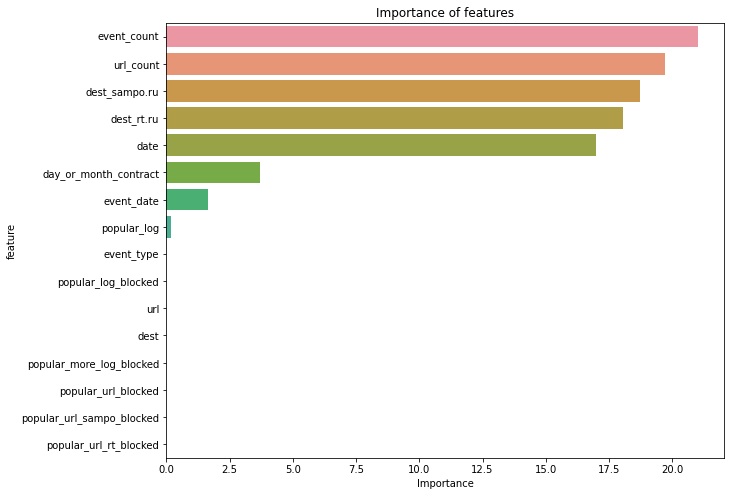

In [545]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    """функция выводит график важных фичей, которые влияют на предсказание"""
    
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (10, len(feature_importances) * 0.5))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
show_feature_importances(X_train.columns, cbc.feature_importances_)

На графике виден ряд фичей, которые бесполезны для выбранной модели. Такие фичи лучше исключить из выборки, чтобы модель лучше предсказывала целевую переменную.

In [546]:
train_full.columns

Index(['contract_id', 'blocked', 'event_date', 'event_type', 'popular_log',
       'popular_log_blocked', 'date', 'url', 'dest', 'day_or_month_contract',
       'event_count', 'dest_rt.ru', 'dest_sampo.ru', 'url_count',
       'popular_more_log_blocked', 'popular_url_blocked',
       'popular_url_sampo_blocked', 'popular_url_rt_blocked'],
      dtype='object')

In [589]:
X_train, X_test, y_train, y_test = train_test_split(train_full.drop(['contract_id', 'blocked',
                                                                    'dest',
                                                                    #'event_count', 
                                                                    #'dest_rt.ru', 
                                                                    #'dest_sampo.ru', 
                                                                    'url_count',
                                                                    'popular_log',
                                                                    'popular_log_blocked',
                                                                    'popular_more_log_blocked', 
                                                                    'popular_url_blocked',
                                                                    'popular_url_sampo_blocked', 
                                                                    'popular_url_rt_blocked']
                                                                    , axis=1)
                                                    , train_full.blocked
                                                    , test_size=0.30, random_state=47)

# список категориальных фичей для Катбуст
categorial_features = ['event_type', 
                       'url'#, 
                       #'dest'
                      ]

pool_train_4 = Pool(data=X_train, label=y_train, 
                    cat_features=categorial_features)
pool_test_4 = Pool(data=X_test, label=y_test, 
                   cat_features=categorial_features)

cbc = CatBoostClassifier(iterations=2000,
                         learning_rate=0.005, 
                         depth=10,
                         #l2_leaf_reg=2.0,
                         #eta=0.1,
                         loss_function='Logloss'#'Logloss'#,CrossEntropy
                         ,custom_metric=['Logloss',
                                          'AUC:hints=skip_train~false', 'F1']
                         ,eval_metric='Recall'
                         ,auto_class_weights='Balanced'#'SqrtBalanced'
                         #,leaf_estimation_method='Newton'#Gradient
                         #,scale_pos_weight=1.0
                         ,use_best_model=True
                        )

cbc.fit(pool_train_4,#X_train, y_train,
        eval_set=pool_test_4,
        verbose=100,
        use_best_model=True,
        plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9684072	test: 0.9649884	best: 0.9649884 (0)	total: 240ms	remaining: 7m 59s
100:	learn: 0.9944211	test: 0.9929109	best: 0.9946470 (5)	total: 24.1s	remaining: 7m 32s
200:	learn: 0.9946092	test: 0.9943576	best: 0.9946470 (5)	total: 47.9s	remaining: 7m 9s
300:	learn: 0.9944211	test: 0.9943576	best: 0.9946470 (5)	total: 1m 12s	remaining: 6m 50s
400:	learn: 0.9966777	test: 0.9959491	best: 0.9959491 (392)	total: 1m 37s	remaining: 6m 27s
500:	learn: 0.9978061	test: 0.9971065	best: 0.9971065 (499)	total: 2m 1s	remaining: 6m 2s
600:	learn: 0.9986209	test: 0.9975405	best: 0.9975405 (581)	total: 2m 24s	remaining: 5m 36s
700:	learn: 0.9988090	test: 0.9976852	best: 0.9979745 (684)	total: 2m 47s	remaining: 5m 10s
800:	learn: 0.9989971	test: 0.9978299	best: 0.9981192 (749)	total: 3m 11s	remaining: 4m 46s
900:	learn: 0.9991851	test: 0.9981192	best: 0.9981192 (749)	total: 3m 38s	remaining: 4m 25s
1000:	learn: 0.9992478	test: 0.9988426	best: 0.9988426 (969)	total: 4m 2s	remaining: 4m 1s
1100:

In [590]:
pred_cbc3 = cbc.predict(X_test)
pred_cbc3
print("Recall score:", recall_score(y_test, pred_cbc3, average='macro'))

Recall score: 0.9986083389629103


In [591]:
print("Recall score difference:", round(recall_score(y_test, pred_cbc3, average='macro')
                                        - recall_score(y_test, pred_cbc, average='macro'), 2))

Recall score difference: 0.08


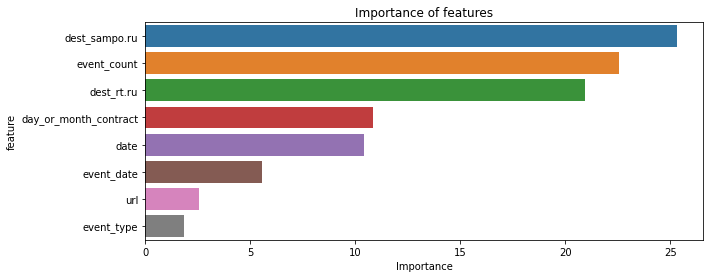

In [592]:
show_feature_importances(X_train.columns, cbc.feature_importances_)

Убрав некоторые фичи качество модели выросло

# Подбор лучших параметров модели

In [442]:
#Объявление CatBoostClassifier и обучение

grid_params = {'iterations': [1000],
               'learning_rate': [0.008],
               'depth': [10, 12],
               'l2_leaf_reg': [1, 2]}

categorial_features = ['event_type', 'url', 'dest']

model_grid = CatBoostClassifier(loss_function='Logloss',#'Logloss'#,CrossEntropy
                               #custom_metric=['Logloss', 'AUC:hints=skip_train~false', 'F1']
                               eval_metric='Recall'
                               ,auto_class_weights='Balanced'#'SqrtBalanced'
                               ,verbose=200
                                #,use_best_model=True
                               ,cat_features=categorial_features)

grid_search_result = model_grid.grid_search(X=train_full.drop(['contract_id', 'blocked']
                                                                   , axis=1),
                                            y=train_full.blocked,
                                            param_grid=grid_params,
                                            cv=3,
                                            stratified=True,
                                            train_size=0.65,
                                            verbose=200, 
                                            plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9853110	test: 0.9849202	best: 0.9849202 (0)	total: 198ms	remaining: 3m 17s
200:	learn: 0.9983829	test: 0.9976321	best: 0.9981306 (185)	total: 45.2s	remaining: 2m 59s
400:	learn: 0.9996631	test: 0.9988784	best: 0.9988784 (399)	total: 1m 28s	remaining: 2m 12s
600:	learn: 0.9997305	test: 0.9986291	best: 0.9988784 (399)	total: 2m 12s	remaining: 1m 28s
800:	learn: 0.9999326	test: 0.9991276	best: 0.9991276 (713)	total: 2m 57s	remaining: 44s
999:	learn: 1.0000000	test: 0.9993769	best: 0.9993769 (959)	total: 3m 40s	remaining: 0us

bestTest = 0.9993768694
bestIteration = 959

0:	loss: 0.9993769	best: 0.9993769 (0)	total: 3m 40s	remaining: 11m 2s
0:	learn: 0.9853110	test: 0.9849202	best: 0.9849202 (0)	total: 236ms	remaining: 3m 56s
200:	learn: 0.9981807	test: 0.9981306	best: 0.9981306 (178)	total: 44.6s	remaining: 2m 57s
400:	learn: 0.9995957	test: 0.9986291	best: 0.9987537 (298)	total: 1m 29s	remaining: 2m 13s
600:	learn: 0.9997305	test: 0.9986291	best: 0.9988784 (437)	total: 2m 16s

In [443]:
model_grid.best_score_, model_grid.best_iteration_

({'learn': {'Recall': 1.0, 'Logloss': 0.0061650498135303175}}, None)

# Предварительные итоги

Модель хорошо предсказывает отток на тренировочных данных разделенных на обучающие выборки, вплоть до 100%, но если загрузить результаты предсказаний на тестовом наборе на платформу, то скор колеблется от 0.60% - 0.70%, что значительно меньше чем полученные результаты.
<br><br>
Возникает предположение, что модели не хватает других фичей с помощью которых модель будет способна более точно предсказывать отток.

Попробую обогатить датасет новыми фичами и заново обучить модель.

In [593]:
train_full.head(3)

,contract_id,blocked,event_date,event_type,popular_log,popular_log_blocked,date,url,dest,day_or_month_contract,event_count,dest_rt.ru,dest_sampo.ru,url_count,popular_more_log_blocked,popular_url_blocked,popular_url_sampo_blocked,popular_url_rt_blocked
0,7780,0,2021-03-17,Отключение услуги Автоплатёж,0,0,2021-04-29,start.sampo.ru,sampo.ru,0,9,0,83,83,0,0,0,0
1,7780,0,2021-03-17,Отключение услуги Автоплатёж,0,0,2021-04-29,profile.sampo.ru,sampo.ru,0,9,0,83,83,0,0,0,0
2,7780,0,2021-03-17,Отключение услуги Автоплатёж,0,0,2021-04-29,vhod.sampo.ru,sampo.ru,0,9,0,83,83,0,0,0,0


In [628]:
# таблица с первыми и последними логами
min_event = df_log.groupby('contract_id')['event_date','event_type'].min()
min_event.rename(columns={'event_date': 'first_event_date', 'event_type': 'first_event_type'}, inplace=True)
max_event = df_log.groupby('contract_id')['event_date','event_type'].max()
max_event.rename(columns={'event_date': 'last_event_date', 'event_type': 'last_event_type'}, inplace=True)
min_event.head(3)

,first_event_date,first_event_type
contract_id,,
3453,2021-03-03,Информер ВК. Показ
3454,2021-04-28,Внутреннее сообщение
3456,2021-03-21,Внутреннее сообщение


In [629]:
max_event.head(3)

,last_event_date,last_event_type
contract_id,,
3453,2021-03-03,Информер ВК. Показ
3454,2021-04-28,Внутреннее сообщение
3456,2021-03-21,Состояние клиентского оборудования


In [630]:
max_event.shape, min_event.shape

((4311, 2), (4311, 2))

Объединяем данные в одну таблицу

In [632]:
log_hist = min_event.merge(max_event, on='contract_id')
log_hist.head(5)

,first_event_date,first_event_type,last_event_date,last_event_type
contract_id,,,,
3453,2021-03-03,Информер ВК. Показ,2021-03-03,Информер ВК. Показ
3454,2021-04-28,Внутреннее сообщение,2021-04-28,Внутреннее сообщение
3456,2021-03-21,Внутреннее сообщение,2021-03-21,Состояние клиентского оборудования
3457,2021-03-09,Информер ВК. Показ,2021-04-29,Информер ВК. Показ
3458,2021-03-01,Включение интернета на 20 минут,2021-04-29,Гарантированный платеж за деньги


In [635]:
log_hist['event_period'] = log_hist.last_event_date-log_hist.first_event_date
log_hist.head(5)

,first_event_date,first_event_type,last_event_date,last_event_type,event_period
contract_id,,,,,
3453,2021-03-03,Информер ВК. Показ,2021-03-03,Информер ВК. Показ,0 days
3454,2021-04-28,Внутреннее сообщение,2021-04-28,Внутреннее сообщение,0 days
3456,2021-03-21,Внутреннее сообщение,2021-03-21,Состояние клиентского оборудования,0 days
3457,2021-03-09,Информер ВК. Показ,2021-04-29,Информер ВК. Показ,51 days
3458,2021-03-01,Включение интернета на 20 минут,2021-04-29,Гарантированный платеж за деньги,59 days


Итого, получили новые данные, которые описывают историю первого обращения клиента и последнего, а так же сколько дней прошло между первым и последним обращением. Аналогичные данные подготовлю по истории посещения сайтов.

In [665]:
# таблица с первыми и последними переходами
min_url = df_named.groupby('contract_id')['date','url'].min()
min_url.rename(columns={'date': 'first_url_date', 'url': 'first_url'}, inplace=True)
max_url = df_named.groupby('contract_id')['date','url'].max()
max_url.rename(columns={'date': 'last_url_date', 'url': 'last_url'}, inplace=True)
url_hist = min_url.merge(max_url, on='contract_id')
url_hist['url_period'] = url_hist.last_url_date-url_hist.first_url_date
url_hist.head(3)

,first_url_date,first_url,last_url_date,last_url,url_period
contract_id,,,,,
3455,2021-04-01,cnt-lbrc-itv01.svc.iptv.rt.ru,2021-04-28,wink.rt.ru,27 days
3458,2021-04-20,fnc.rt.ru,2021-04-20,fnc.rt.ru,0 days
3459,2021-04-28,petrozavodsk.speedtest.rt.ru.prod.hosts.ooklas...,2021-04-28,speedtest.sampo.ru.prod.hosts.ooklaserver.net,0 days


In [666]:
max_url.shape, min_url.shape, url_hist.shape

((196148, 2), (196148, 2), (196148, 5))

In [781]:
url_hist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196148 entries, 3455 to 274786
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype          
---  ------          --------------   -----          
 0   first_url_date  196148 non-null  datetime64[ns] 
 1   first_url       196148 non-null  object         
 2   last_url_date   196148 non-null  datetime64[ns] 
 3   last_url        196148 non-null  object         
 4   url_period      196148 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), object(2), timedelta64[ns](1)
memory usage: 9.0+ MB


Cбор данных по обращениям в марте и апреле

In [946]:
event_counts = pd.DataFrame(df_log.query("'2021-03-01' <= event_date < '2021-03-31'")\
                                        .groupby("contract_id")['contract_id'].count())

event_counts['event_count_april'] = df_log.query("'2021-04-01' <= event_date < '2021-04-30'")\
                                                             .groupby("contract_id")['contract_id'].count()
event_counts.columns = ['event_count_march', 'event_count_april']
event_counts = event_counts.fillna(0).astype(int)
event_counts['all_event_count'] =  event_counts['event_count_april']+event_counts['event_count_march']
event_counts.head(1)

,event_count_march,event_count_april,all_event_count
contract_id,,,
3453,1,0,1


Сбор данных по переходам по ссылкам в марте и апреле

In [947]:
url_counts = pd.DataFrame(df_named.query("'2021-03-01' <= date < '2021-03-31'")\
                                        .groupby("contract_id")['contract_id'].count())

url_counts['url_count_april'] = df_named.query("'2021-04-01' <= date < '2021-04-30'")\
                                                             .groupby("contract_id")['contract_id'].count()
url_counts.columns = ['url_count_march', 'url_count_april']
url_counts = url_counts.fillna(0).astype(int)
url_counts['all_url_count'] =  url_counts['url_count_april'] + url_counts['url_count_march']
url_counts.head(1)

,url_count_march,url_count_april,all_url_count
contract_id,,,
3460,8,0,8


In [970]:
pd.DataFrame(df_named.query("'2021-03-01' <= date < '2021-03-31'")\
                                        .groupby(["contract_id"])['contract_id'].count()).drop_duplicates

<bound method DataFrame.drop_duplicates of              contract_id
contract_id             
3460                   8
3464                   1
3490                   2
3494                   1
3495                  48
...                  ...
270923                 3
271241                63
271819                 4
271820                 2
273472                 1

[193955 rows x 1 columns]>

In [964]:
url_counts.shape

(193955, 3)

In [1056]:
new_df = df_train.copy()
new_df.head(1)

,contract_id,blocked
0,7780,0


In [1057]:
# добавляем тип контракта
new_df = new_df.merge(df_type_contract, on='contract_id')
new_df.shape

(5991, 3)

In [1058]:
# добавляем историю логов
new_df = new_df.merge(log_hist, on='contract_id', how='left')
new_df.shape

(5991, 8)

In [1059]:
# добавляем данные по количеству событий
new_df = new_df.merge(event_counts, on='contract_id', how='left')
new_df.shape

(5991, 11)

In [1060]:
# добавляем историю ссылок
new_df = new_df.merge(url_hist, on='contract_id', how='left')
new_df.shape

(5991, 16)

In [1061]:
named_transform = pd.get_dummies(df_named[['contract_id', 'dest']]).groupby(['contract_id']).sum()
new_df = new_df.merge(named_transform , on="contract_id", how='left')

In [1062]:
new_df.shape

(5991, 18)

In [1063]:
# добавляем данные по количеству ссылок
new_df = new_df.merge(url_counts, on='contract_id', how='left')
new_df.shape

(5991, 21)

In [955]:
new_df.query('blocked==1').groupby(['last_event_type'])['contract_id'].count().nlargest(15)

last_event_type
Информер ВК. Показ                                                  84
Обращение в службу заботы о клиентах                                76
Включение интернета на 20 минут                                     45
Гарантированный платеж за деньги                                    39
Отключение услуги Аренда ТВ-приставки                               34
Смена тарифа                                                        33
Состояние клиентского оборудования                                  27
Предложение ТВ                                                      20
Просмотр раздела Тайный покупатель                                  20
Смена пароля                                                        20
Перенос денежных средств                                            18
Получение подарка в ЛК: сутки интернета на максимальной скорости    18
Отключение услуги Автоплатёж                                        11
Предложение IPTV                                             

In [989]:
new_df.head(5)

,contract_id,blocked,day_or_month_contract,first_event_date,first_event_type,last_event_date,last_event_type,event_period,event_count_march,event_count_april,all_event_count,first_url_date,first_url,last_url_date,last_url,url_period,dest_rt.ru,dest_sampo.ru,url_count_march,url_count_april,all_url_count
0,7780,0,0,2021-03-17 00:00:00,Обращение в службу заботы о клиентах,2021-04-28 00:00:00,Смена схемы оплаты,42 days,2.0,7.0,9.0,2021-04-28 00:00:00,chat.sampo.ru,2021-04-29 00:00:00,wifi.sampo.ru,1 days,0.0,83.0,0.0,0.0,0.0
1,7785,0,0,2021-03-30 00:00:00,Реестр договоров,2021-03-30 00:00:00,Реестр договоров,0 days,1.0,0.0,1.0,2021-04-03 00:00:00,fdb00.sampo.ru,2021-04-22 00:00:00,static02.rupor.sampo.ru,19 days,3.0,7.0,0.0,0.0,0.0
2,7794,0,0,0,0,0,0,0 days,0.0,0.0,0.0,0,0,0,0,0 days,0.0,0.0,0.0,0.0,0.0
3,7795,0,1,2021-03-08 00:00:00,Включение интернета на 20 минут,2021-03-24 00:00:00,Информер ВК. Показ,16 days,7.0,0.0,7.0,0,0,0,0,0 days,0.0,0.0,0.0,0.0,0.0
4,7798,0,0,2021-03-13 00:00:00,Информер ВК. Показ,2021-04-17 00:00:00,Информер ВК. Показ,35 days,2.0,1.0,3.0,0,0,0,0,0 days,0.0,0.0,0.0,0.0,0.0


In [1064]:
# преобразование дат

dates = ['first_event_date', 'last_event_date', 'first_url_date', 'last_url_date']

for i in dates:
    new_df[i] = new_df[i].fillna(new_df[i],axis=0)
    new_df[i] = new_df[i].fillna(0)
    #new_df[i] = pd.to_datetime(new_df[i], format='%Y-%m-%d').dt.date
    
new_df.event_period.fillna('0 days', inplace=True)
new_df.url_period.fillna('0 days', inplace=True)

#new_df.fillna(0, inplace=True)

In [1065]:
new_df.isnull()
new_df

,contract_id,blocked,day_or_month_contract,first_event_date,first_event_type,last_event_date,last_event_type,event_period,event_count_march,event_count_april,all_event_count,first_url_date,first_url,last_url_date,last_url,url_period,dest_rt.ru,dest_sampo.ru,url_count_march,url_count_april,all_url_count
0,7780,0,0,2021-03-17 00:00:00,Обращение в службу заботы о клиентах,2021-04-28 00:00:00,Смена схемы оплаты,42 days,2.0,7.0,9.0,2021-04-28 00:00:00,chat.sampo.ru,2021-04-29 00:00:00,wifi.sampo.ru,1 days,0.0,83.0,NaN,NaN,NaN
1,7785,0,0,2021-03-30 00:00:00,Реестр договоров,2021-03-30 00:00:00,Реестр договоров,0 days,1.0,0.0,1.0,2021-04-03 00:00:00,fdb00.sampo.ru,2021-04-22 00:00:00,static02.rupor.sampo.ru,19 days,3.0,7.0,NaN,NaN,NaN
2,7794,0,0,0,NaN,0,NaN,0 days,NaN,NaN,NaN,0,NaN,0,NaN,0 days,NaN,NaN,NaN,NaN,NaN
3,7795,0,1,2021-03-08 00:00:00,Включение интернета на 20 минут,2021-03-24 00:00:00,Информер ВК. Показ,16 days,7.0,0.0,7.0,0,NaN,0,NaN,0 days,NaN,NaN,NaN,NaN,NaN
4,7798,0,0,2021-03-13 00:00:00,Информер ВК. Показ,2021-04-17 00:00:00,Информер ВК. Показ,35 days,2.0,1.0,3.0,0,NaN,0,NaN,0 days,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5986,274601,1,1,2021-04-20 00:00:00,Включение интернета на 20 минут с IVR,2021-04-20 00:00:00,Смена тарифа,0 days,NaN,NaN,NaN,0,NaN,0,NaN,0 days,NaN,NaN,NaN,NaN,NaN
5987,274710,1,0,2021-04-20 00:00:00,Внутреннее сообщение,2021-04-20 00:00:00,Смена пароля,0 days,NaN,NaN,NaN,0,NaN,0,NaN,0 days,NaN,NaN,NaN,NaN,NaN
5988,274782,1,0,2021-04-15 00:00:00,Оборудование,2021-04-22 00:00:00,Реестр договоров,7 days,NaN,NaN,NaN,0,NaN,0,NaN,0 days,NaN,NaN,NaN,NaN,NaN
5989,274786,1,1,2021-04-15 00:00:00,Включение интернета на 20 минут с IVR,2021-04-29 00:00:00,Реестр договоров,14 days,NaN,NaN,NaN,2021-04-05 00:00:00,fnc.rt.ru,2021-04-05 00:00:00,fnc.rt.ru,0 days,1.0,0.0,NaN,NaN,NaN


Остались пропущенные значения в некоторых колонках. Заполню из нулями

In [ ]:
new_df.fillna(0, inplace=True)

In [1067]:
# перевод колонок с float в формат int
new_df['dest_rt.ru'] = new_df['dest_rt.ru'].astype(int)
new_df['dest_sampo.ru'] = new_df['dest_sampo.ru'].astype(int)
new_df.head(1)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [820]:
new_df.query('blocked==1 & last_url!=0').groupby(['last_url'])['contract_id'].count().nlargest(15)

last_url
wifi.sampo.ru                                    27
fnc.rt.ru                                        25
www.rt.ru                                        12
speedtest.sampo.ru.prod.hosts.ooklaserver.net    11
vitrina.sampo.ru                                 11
statserv.sampo.ru                                 7
wink.rt.ru                                        7
data.sampo.ru                                     5
speedtest.sampo.ru                                5
vhod.sampo.ru                                     5
rt-static.rt.ru                                   4
sampo.ru                                          4
mlk.rt.ru                                         3
ppk.sampo.ru                                      3
moigorod.sampo.ru                                 2
Name: contract_id, dtype: int64

Последние события по ушедшим клиентам немного отличаются от тех, что были выявлены ранее на большом массиве данных.
<br><br>
В топе попрежнему "Информер ВК", обращение в службу заботы о клиентах, включение интернета на 20 минут и пр. Появились новые события связанные с клиентским оборудованием, предложением ТВ и просмотр раздела тайного покупателя
<br><br>
Для эксперимента попробую добавить новые фичи связанные с событиями и ссылками, которые посещали ушедшие клиенты, тк возможно модель будет лучше отслеживать ушедших клиентов

In [828]:
new_df.query('blocked==1').groupby(['first_event_type'])['contract_id'].count().nlargest(15)

first_event_type
Включение интернета на 20 минут            174
0                                          161
Информер ВК. Показ                          71
Гарантированный платеж за деньги            48
Включение интернета на 20 минут с IVR       36
Обращение в службу заботы о клиентах        35
Внутреннее сообщение                        25
Добавление в Обращались с номеров           23
Изменение истории                           18
Активация точки подключения на сутки        17
Активация гарантированного платежа          12
Абонент оставил отзыв в Личном кабинете      9
Включение IPTV-пакета                        9
Оборудование                                 8
Активация ГП с IVR                           7
Name: contract_id, dtype: int64

In [1068]:
def new_feature(df, n, l):
    if df.blocked==1 and n in l:
        return 1
    else:
        return 0

# подготовка списков с топ-событиями и ссылками по ушедшим клиентам
block_first_event = list(new_df.query('blocked==1 & last_url!=0').groupby(['first_event_type'])['contract_id'].count().nlargest(15)\
                        .index)
block_last_event = list(new_df.query('blocked==1 & last_url!=0').groupby(['last_event_type'])['contract_id'].count().nlargest(15)\
                        .index)
block_first_url = list(new_df.query('blocked==1 & last_url!=0').groupby(['first_url'])['contract_id'].count()\
                       .nlargest(15).index)
block_last_url = list(new_df.query('blocked==1 & last_url!=0').groupby(['last_url'])['contract_id'].count()\
                      .nlargest(15).index)

# маркировка наиболее частых событий по ушедшим клиентам
new_df['log_blocked_first_event'] = new_df.apply(lambda x: new_feature(x, x.first_event_type, block_first_event)
                                                     , axis=1)
new_df['log_blocked_last_event'] = new_df.apply(lambda x: new_feature(x, x.last_event_type, block_last_event)
                                                     , axis=1)

# маркировка наиболее частых ссылок по ушедшим клиентам
new_df['blocked_first_url'] = new_df.apply(lambda x: new_feature(x, x.first_url, block_first_event)
                                                     , axis=1)
new_df['blocked_last_url'] = new_df.apply(lambda x: new_feature(x, x.last_url, block_last_event)
                                                     , axis=1)

# сумма всех ссылок
new_df['url_sum'] = new_df['dest_rt.ru'] + new_df['dest_sampo.ru']


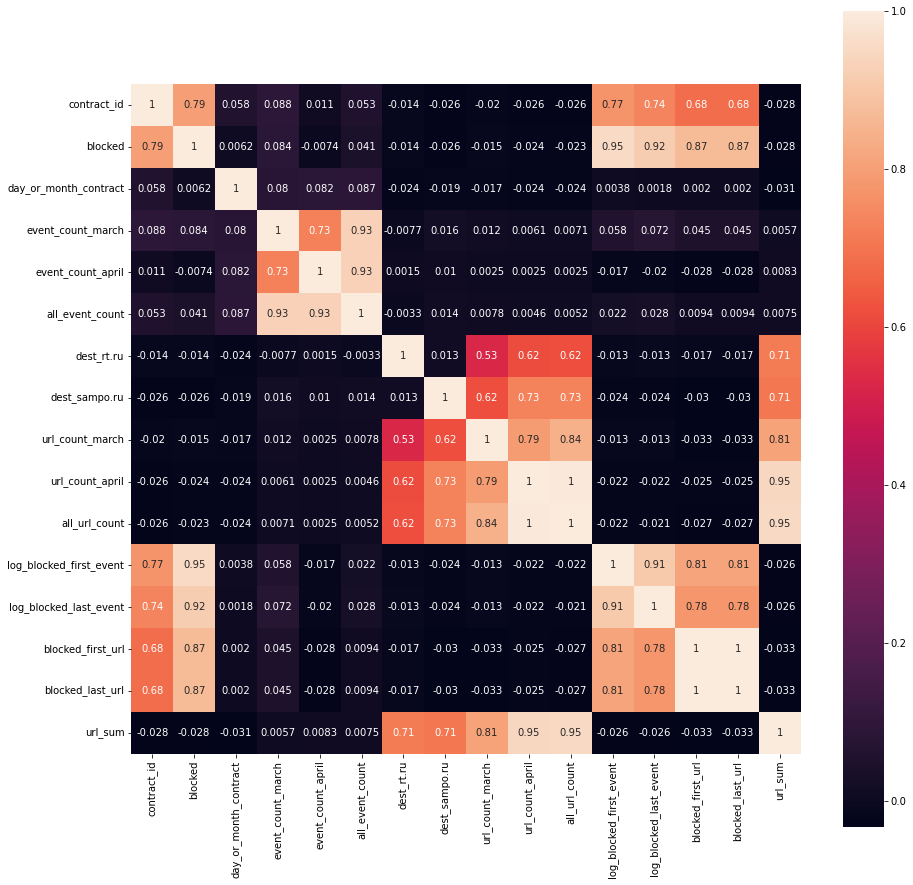

In [996]:
plt.rcParams['figure.figsize']=(15,15)

corr = new_df.corr()
g = sns.heatmap(corr, square = True, annot=True)

Новые фичи хорошо корреллируют с номером контракта и признаком оттока. Построим график без первых двух колонок, оценить, как изменится корреляция

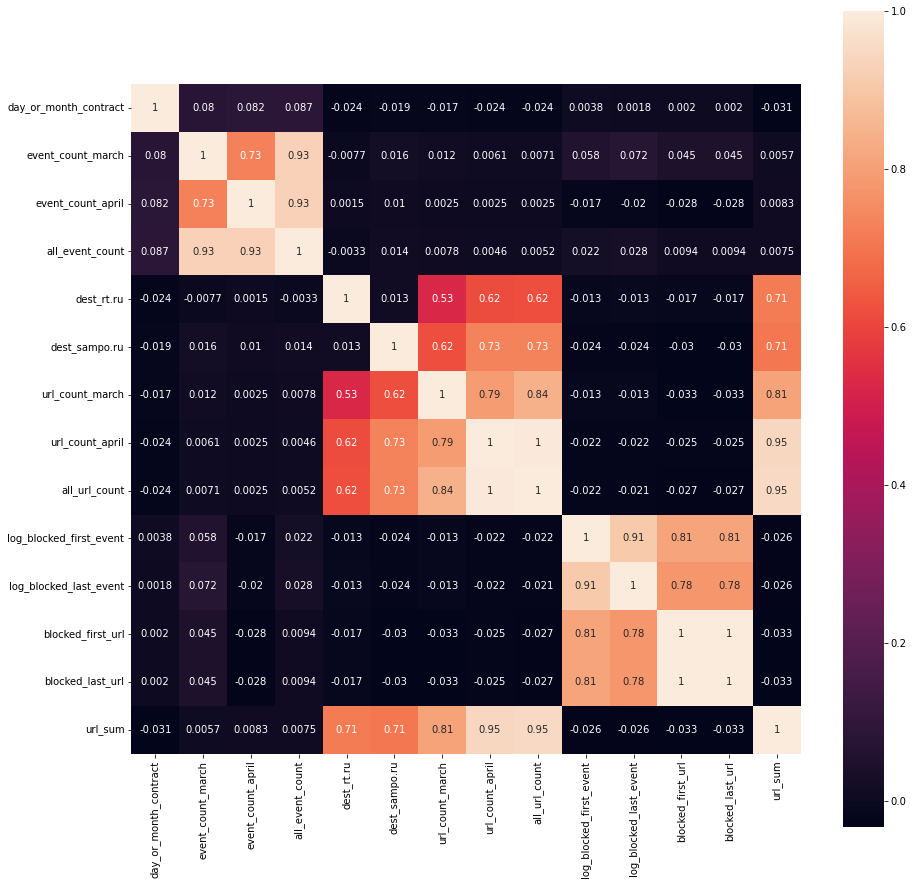

In [997]:
plt.rcParams['figure.figsize']=(15,15)

corr = new_df.drop(['contract_id', 'blocked'], axis=1).corr()
g = sns.heatmap(corr, square = True, annot=True)

In [998]:
display(new_df.describe())

,contract_id,blocked,day_or_month_contract,event_period,event_count_march,event_count_april,all_event_count,url_period,dest_rt.ru,dest_sampo.ru,url_count_march,url_count_april,all_url_count,log_blocked_first_event,log_blocked_last_event,blocked_first_url,blocked_last_url,url_sum
count,5991.0,5991.0,5991.0,5991,5991.0,5991.0,5991.0,5991,5991.0,5991.0,5991.0,5991.0,5991.0,5991.0,5991.0,5991.0,5991.0,5991.0
mean,48879.1,0.1,0.4,12 days 21:48:02.523785678,1.9,1.3,3.2,5 days 19:53:08.983475212,7.8,14.0,3.0,13.4,16.4,0.1,0.1,0.1,0.1,21.8
std,49408.0,0.3,0.5,18 days 13:55:05.189725713,4.1,4.1,7.7,10 days 08:34:13.802442086,147.1,146.1,28.8,169.9,193.6,0.3,0.3,0.3,0.3,208.7
min,7780.0,0.0,0.0,0 days 00:00:00,0.0,0.0,0.0,0 days 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,15000.5,0.0,0.0,0 days 00:00:00,0.0,0.0,0.0,0 days 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,43941.0,0.0,0.0,0 days 00:00:00,0.0,0.0,0.0,0 days 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,51187.5,0.0,1.0,30 days 00:00:00,3.0,1.0,4.0,8 days 00:00:00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
max,274918.0,1.0,1.0,59 days 00:00:00,141.0,211.0,352.0,35 days 00:00:00,6922.0,6627.0,1422.0,6738.0,6910.0,1.0,1.0,1.0,1.0,6934.0


In [1069]:
new_df['event_period'] = pd.to_numeric(new_df['event_period'].dt.days, downcast='integer')
new_df['url_period'] = pd.to_numeric(new_df['url_period'].dt.days, downcast='integer')

In [1075]:
new_df.head(1)

,contract_id,blocked,day_or_month_contract,first_event_date,first_event_type,last_event_date,last_event_type,event_period,event_count_march,event_count_april,all_event_count,first_url_date,first_url,last_url_date,last_url,url_period,dest_rt.ru,dest_sampo.ru,url_count_march,url_count_april,all_url_count,log_blocked_first_event,log_blocked_last_event,blocked_first_url,blocked_last_url,url_sum
0,7780,0,0,2021-03-17 00:00:00,Обращение в службу заботы о клиентах,2021-04-28 00:00:00,Смена схемы оплаты,42,2.0,7.0,9.0,2021-04-28 00:00:00,chat.sampo.ru,2021-04-29 00:00:00,wifi.sampo.ru,1,0.0,83.0,NaN,NaN,NaN,0,0,0,0,83.0


In [1076]:
new_df.fillna(0, inplace=True)

In [1077]:
x_new = new_df.drop(['contract_id', 'blocked', 
                     'first_event_date', 'last_event_date',
                     'first_url_date', 'last_url_date'], axis=1)
y_new = new_df['blocked']

In [1080]:
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(x_new
                                                    , y_new
                                                    , test_size=0.50, random_state=47)

In [1082]:
cf = ['first_event_type', 'last_event_type', 'first_url', 'last_url']

new_pool = Pool(X_train_n, y_train_n, cat_features=cf)
new_pool_test = Pool(X_test_n, y_test_n, cat_features=cf)

cbc2 = CatBoostClassifier(iterations=1000,
                         learning_rate=0.008, 
                         depth=10,
                         loss_function='Logloss'#'Logloss'#,CrossEntropy
                         ,custom_metric=['Logloss',
                                          'AUC:hints=skip_train~false', 'F1']
                         ,eval_metric='Recall'
                         ,auto_class_weights='Balanced'#'SqrtBalanced'
                         ,cat_features=cf
                        )

cbc2.fit(new_pool,#X_train, y_train,
        eval_set=new_pool_test,
        verbose=100,
        use_best_model=True,
        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7619048	test: 0.7348066	best: 0.7348066 (0)	total: 6.91ms	remaining: 6.9s
100:	learn: 0.7619048	test: 0.7624309	best: 0.7624309 (10)	total: 889ms	remaining: 7.91s
200:	learn: 0.7708333	test: 0.7624309	best: 0.7624309 (10)	total: 1.87s	remaining: 7.44s
300:	learn: 0.8333333	test: 0.7624309	best: 0.7624309 (10)	total: 2.77s	remaining: 6.44s
400:	learn: 0.8750000	test: 0.7596685	best: 0.7624309 (10)	total: 3.7s	remaining: 5.53s
500:	learn: 0.9047619	test: 0.7569061	best: 0.7624309 (10)	total: 4.6s	remaining: 4.58s
600:	learn: 0.9107143	test: 0.7569061	best: 0.7624309 (10)	total: 5.5s	remaining: 3.65s
700:	learn: 0.9196429	test: 0.7569061	best: 0.7624309 (10)	total: 6.36s	remaining: 2.71s
800:	learn: 0.9196429	test: 0.7569061	best: 0.7624309 (10)	total: 7.24s	remaining: 1.8s
900:	learn: 0.9196429	test: 0.7569061	best: 0.7624309 (10)	total: 8.1s	remaining: 890ms
999:	learn: 0.9196429	test: 0.7569061	best: 0.7624309 (10)	total: 9.01s	remaining: 0us

bestTest = 0.7624309392
bestIt

In [1050]:
new_test = df_sample_solution.copy()
new_test = new_test.merge(df_type_contract, on='contract_id')
new_test = new_test.merge(log_hist, on='contract_id', how='left')
new_test = new_test.merge(event_counts, on='contract_id', how='left')
new_test = new_test.merge(url_hist, on='contract_id', how='left')
named_transform = pd.get_dummies(df_named[['contract_id', 'dest']]).groupby(['contract_id']).sum()
new_test = new_test.merge(named_transform , on="contract_id", how='left')
new_test = new_test.merge(url_counts, on='contract_id', how='left')

new_test.event_period.fillna('0 days', inplace=True)
new_test.url_period.fillna('0 days', inplace=True)

#new_test['dest_rt.ru'] = new_test['dest_rt.ru'].astype(int)
#new_test['dest_sampo.ru'] = new_test['dest_sampo.ru'].astype(int)

block_first_event = list(new_test.query('blocked==1 & last_url!=0').groupby(['first_event_type'])['contract_id'].count().nlargest(15)\
                        .index)
block_last_event = list(new_test.query('blocked==1 & last_url!=0').groupby(['last_event_type'])['contract_id'].count().nlargest(15)\
                        .index)
block_first_url = list(new_test.query('blocked==1 & last_url!=0').groupby(['first_url'])['contract_id'].count()\
                       .nlargest(15).index)
block_last_url = list(new_test.query('blocked==1 & last_url!=0').groupby(['last_url'])['contract_id'].count()\
                      .nlargest(15).index)

# маркировка наиболее частых событий по ушедшим клиентам
new_test['log_blocked_first_event'] = new_test.apply(lambda x: new_feature(x, x.first_event_type, block_first_event)
                                                     , axis=1)
new_test['log_blocked_last_event'] = new_test.apply(lambda x: new_feature(x, x.last_event_type, block_last_event)
                                                     , axis=1)

# маркировка наиболее частых ссылок по ушедшим клиентам
new_test['blocked_first_url'] = new_test.apply(lambda x: new_feature(x, x.first_url, block_first_event)
                                                     , axis=1)
new_test['blocked_last_url'] = new_test.apply(lambda x: new_feature(x, x.last_url, block_last_event)
                                                     , axis=1)

# сумма всех ссылок
new_test['url_sum'] = new_test['dest_rt.ru'] + new_test['dest_sampo.ru']

new_test['event_period'] = pd.to_numeric(new_test['event_period'].dt.days, downcast='integer')
new_test['url_period'] = pd.to_numeric(new_test['url_period'].dt.days, downcast='integer')

In [1051]:
new_test.fillna(0, inplace=True)

In [1052]:
new_test.head(5)

,contract_id,blocked,day_or_month_contract,first_event_date,first_event_type,last_event_date,last_event_type,event_period,event_count_march,event_count_april,all_event_count,first_url_date,first_url,last_url_date,last_url,url_period,dest_rt.ru,dest_sampo.ru,url_count_march,url_count_april,all_url_count,log_blocked_first_event,log_blocked_last_event,blocked_first_url,blocked_last_url,url_sum
0,3453,0,0,2021-03-03 00:00:00,Информер ВК. Показ,2021-03-03 00:00:00,Информер ВК. Показ,0,1.0,0.0,1.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0
1,3454,0,1,2021-04-28 00:00:00,Внутреннее сообщение,2021-04-28 00:00:00,Внутреннее сообщение,0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0
2,3455,0,1,0,0,0,0,0,0.0,0.0,0.0,2021-04-01 00:00:00,cnt-lbrc-itv01.svc.iptv.rt.ru,2021-04-28 00:00:00,wink.rt.ru,27,5.0,19.0,0.0,0.0,0.0,0,0,0,0,24.0
3,3456,0,0,2021-03-21 00:00:00,Внутреннее сообщение,2021-03-21 00:00:00,Состояние клиентского оборудования,0,4.0,0.0,4.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0
4,3457,0,0,2021-03-09 00:00:00,Информер ВК. Показ,2021-04-29 00:00:00,Информер ВК. Показ,51,3.0,1.0,4.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0


In [1044]:
df_sample_solution.shape, new_test.shape

((810, 2), (814, 26))

In [1046]:
new_test = new_test.drop_duplicates()

In [1073]:
x_test = new_test.drop(['contract_id', 'blocked', 
                     'first_event_date', 'last_event_date',
                     'first_url_date', 'last_url_date'], axis=1)
#y_test = new_test['blocked']

test_pool = Pool(x_test, cat_features=cf)

In [1083]:
test_predict = cbc2.predict(test_pool)
test_predict

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Предсказание на тестовом наборе

In [362]:
test_full = df_sample_solution.copy()
test_full = test_full.merge(df_log, on='contract_id', how='left').fillna(0)
test_full = test_full.merge(df_named, on='contract_id', how='left').fillna(0)
test_full.head(3)

,contract_id,blocked,event_date,event_type,popular_log,popular_log_blocked,date,url,dest
0,3453,0,2021-03-03 00:00:00,Информер ВК. Показ,1.0,1.0,0,0,0
1,3454,0,2021-04-28 00:00:00,Внутреннее сообщение,0.0,1.0,0,0,0
2,3455,0,0,0,0.0,0.0,2021-04-25 00:00:00,swap.sampo.ru,sampo.ru


Обогащение фичами, как и у обучающего набора

In [363]:
test_full = df_sample_solution.copy()
test_full = test_full.merge(df_log, on='contract_id', how='left')#.fillna(0)
test_full = test_full.merge(df_named, on='contract_id', how='left')#.fillna(0)
test_full = test_full.merge(df_type_contract, on='contract_id', how='left')#.fillna(0)
test_full = test_full.merge(count_log , on="contract_id", how='left')#.fillna(0)
named_transform = pd.get_dummies(df_named[['contract_id', 'dest']]).groupby(['contract_id']).sum()
test_full = test_full.merge(named_transform , on="contract_id", how='left')#.fillna(0)
test_full = test_full.merge(count_url, on="contract_id", how='left')

test_full.drop(['event_date_y', 'event_type_y'], axis=1, inplace=True)
test_full.rename(columns={'event_date_x': 'event_date', 'popular_log_x': 'popular_log',
                           'popular_log_y': 'event_count', 'event_type_x': 'event_type'}, inplace=True)
#test_full['event_count'] = test_full['event_count'].astype(int)

categorial_features = ['event_type', 'url', 'dest']

test_full

,contract_id,blocked,event_date,event_type,popular_log,popular_log_blocked,date,url,dest,day_or_month_contract,event_count,dest_rt.ru,dest_sampo.ru,url_count
0,3453,0,2021-03-03,Информер ВК. Показ,1.0,1.0,NaT,NaN,NaN,0,1.0,NaN,NaN,NaN
1,3454,0,2021-04-28,Внутреннее сообщение,0.0,1.0,NaT,NaN,NaN,1,1.0,NaN,NaN,NaN
2,3455,0,NaT,NaN,NaN,NaN,2021-04-25,swap.sampo.ru,sampo.ru,1,NaN,5.0,19.0,24.0
3,3455,0,NaT,NaN,NaN,NaN,2021-04-08,kino.sampo.ru,sampo.ru,1,NaN,5.0,19.0,24.0
4,3455,0,NaT,NaN,NaN,NaN,2021-04-08,go.sampo.ru,sampo.ru,1,NaN,5.0,19.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51951,4261,0,2021-03-29,Информер ВК. Показ,1.0,1.0,NaT,NaN,NaN,0,18.0,NaN,NaN,NaN
51952,4261,0,2021-03-29,Информер ВК. Показ,1.0,1.0,NaT,NaN,NaN,0,18.0,NaN,NaN,NaN
51953,4261,0,2021-03-31,Включение интернета на 20 минут,1.0,1.0,NaT,NaN,NaN,0,18.0,NaN,NaN,NaN
51954,4262,0,2021-03-16,Включение интернета на 20 минут,1.0,1.0,NaT,NaN,NaN,0,2.0,NaN,NaN,NaN


In [364]:
# преобразование дат

test_full.event_date = test_full.event_date.fillna(test_full.date,axis=0)
test_full.event_date = test_full.event_date.fillna(test_full.event_date.mean())
test_full.date = test_full.date.fillna(test_full.event_date,axis=0)
test_full.date = test_full.date.fillna(test_full.date.mean())

test_full

,contract_id,blocked,event_date,event_type,popular_log,popular_log_blocked,date,url,dest,day_or_month_contract,event_count,dest_rt.ru,dest_sampo.ru,url_count
0,3453,0,2021-03-03,Информер ВК. Показ,1.0,1.0,2021-03-03,NaN,NaN,0,1.0,NaN,NaN,NaN
1,3454,0,2021-04-28,Внутреннее сообщение,0.0,1.0,2021-04-28,NaN,NaN,1,1.0,NaN,NaN,NaN
2,3455,0,2021-04-25,NaN,NaN,NaN,2021-04-25,swap.sampo.ru,sampo.ru,1,NaN,5.0,19.0,24.0
3,3455,0,2021-04-08,NaN,NaN,NaN,2021-04-08,kino.sampo.ru,sampo.ru,1,NaN,5.0,19.0,24.0
4,3455,0,2021-04-08,NaN,NaN,NaN,2021-04-08,go.sampo.ru,sampo.ru,1,NaN,5.0,19.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51951,4261,0,2021-03-29,Информер ВК. Показ,1.0,1.0,2021-03-29,NaN,NaN,0,18.0,NaN,NaN,NaN
51952,4261,0,2021-03-29,Информер ВК. Показ,1.0,1.0,2021-03-29,NaN,NaN,0,18.0,NaN,NaN,NaN
51953,4261,0,2021-03-31,Включение интернета на 20 минут,1.0,1.0,2021-03-31,NaN,NaN,0,18.0,NaN,NaN,NaN
51954,4262,0,2021-03-16,Включение интернета на 20 минут,1.0,1.0,2021-03-16,NaN,NaN,0,2.0,NaN,NaN,NaN


In [469]:
# подсчет заполненных значений
test_full.count()

contract_id              51956
blocked                  51956
event_date               51956
event_type               51956
popular_log              51956
popular_log_blocked      51956
date                     51956
url                      51956
dest                     51956
day_or_month_contract    51956
event_count              51956
dest_rt.ru               51956
dest_sampo.ru            51956
url_count                51956
dtype: int64

Оставшиеся пустые значения заполню нолями

In [365]:
test_full['event_date'] = test_full['event_date'].astype(object).where(test_full['event_date'].notnull(),np.nan)
test_full['date'] = test_full['date'].astype(object).where(test_full['date'].notnull(),np.nan)
test_full.fillna(0, inplace=True)
test_full.popular_log = test_full.popular_log.astype(int)
test_full.popular_log_blocked = test_full.popular_log_blocked.astype(int)
test_full.event_count = test_full.event_count.astype(int)
test_full.url_count = test_full.url_count.astype(int)
test_full['dest_rt.ru'] = test_full['dest_rt.ru'].astype(int)
test_full['dest_sampo.ru'] = test_full['dest_sampo.ru'].astype(int)

test_full.head(5)

,contract_id,blocked,event_date,event_type,popular_log,popular_log_blocked,date,url,dest,day_or_month_contract,event_count,dest_rt.ru,dest_sampo.ru,url_count
0,3453,0,2021-03-03,Информер ВК. Показ,1,1,2021-03-03,0,0,0,1,0,0,0
1,3454,0,2021-04-28,Внутреннее сообщение,0,1,2021-04-28,0,0,1,1,0,0,0
2,3455,0,2021-04-25,0,0,0,2021-04-25,swap.sampo.ru,sampo.ru,1,0,5,19,24
3,3455,0,2021-04-08,0,0,0,2021-04-08,kino.sampo.ru,sampo.ru,1,0,5,19,24
4,3455,0,2021-04-08,0,0,0,2021-04-08,go.sampo.ru,sampo.ru,1,0,5,19,24


In [489]:
final_test_pool = Pool(data=test_full.drop(['contract_id', 'blocked'], axis=1).fillna(0)
                       , cat_features=categorial_features)

In [584]:
# предсказание модели с меньшим количеством фичей

cat_f = ['event_type', 'url', 'dest']

final_test_pool2 = Pool(data=test_full.drop(['contract_id', 
                                             'blocked', 
                                             'dest_rt.ru', 
                                             'dest_sampo.ru', 
                                             'url_count'#,
                                             #'popular_more_log_blocked', 
                                             #'popular_url_blocked',
                                             #'popular_url_sampo_blocked', 
                                             #'popular_url_rt_blocked'
                                            ]
                                             , axis=1).fillna(0)
                       , cat_features=cat_f)


In [585]:
cbc.get_params()

{'iterations': 2000,
 'learning_rate': 0.005,
 'depth': 10,
 'loss_function': 'Logloss',
 'use_best_model': True,
 'auto_class_weights': 'Balanced',
 'custom_metric': ['Logloss', 'AUC:hints=skip_train~false', 'F1'],
 'eval_metric': 'Recall'}

In [587]:
pred = cbc.predict(final_test_pool)
pred

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
pred2 = cbc.predict(final_test_pool2)
pred2

In [395]:
pred.shape, pred2.shape

((51956,), (51956,))

In [451]:
mg_pred = model_grid.predict(final_test_pool)
mg_pred

array([0, 0, 0, ..., 0, 1, 1])

# Подготовка файла для проверки результата на площадке чемпионата

In [588]:
test_data = pd.DataFrame(test_full['contract_id'].copy())
test_data['blocked'] = pred
test_data.drop_duplicates(subset=['contract_id'], keep='first', inplace=True)
test_data.set_index('contract_id', inplace=True)

test_data.to_csv('test_main_210922_3.csv')

In [570]:
test_data2 = pd.DataFrame(test_full['contract_id'].copy())
test_data2['blocked'] = pred2
test_data2.drop_duplicates(subset=['contract_id'], keep='first', inplace=True)
test_data2.set_index('contract_id', inplace=True)

test_data2.to_csv('test_short_210922_1.csv')

In [452]:
test_data3 = pd.DataFrame(test_full['contract_id'].copy())
test_data3['blocked'] = mg_pred
test_data3.drop_duplicates(subset=['contract_id'], keep='first', inplace=True)
test_data3.set_index('contract_id', inplace=True)

test_data2.to_csv('test3_grid_200922_1.csv')

In [244]:
# скор по результатам сверки с сайтом - 0.618182
model_params_19922_2 = {'iterations': 2000,
                        'learning_rate': 0.008,
                        'depth': 10,
                        'loss_function': 'Logloss',
                        'auto_class_weights': 'Balanced',
                        'custom_metric': ['Logloss', 'AUC:hints=skip_train~false', 'F1'],
                        'eval_metric': 'Recall'}

In [278]:
# скор по результатам сверки с сайтом - 0.697922
model_params_20922_1 =  {'iterations': 1000,
                         'learning_rate': 0.008,
                         'depth': 10,
                         'loss_function': 'Logloss',
                         'auto_class_weights': 'Balanced',
                         'custom_metric': ['Logloss', 'AUC:hints=skip_train~false', 'F1'],
                         'eval_metric': 'Recall'}

In [ ]:
# скор по результатам сверки с сайтом - 0.71
model_params_20922_1 =  {'iterations': 1000,
                         'learning_rate': 0.008,
                         'depth': 10,
                         'loss_function': 'Logloss',
                         'auto_class_weights': 'Balanced',
                         'custom_metric': ['Logloss', 'AUC:hints=skip_train~false', 'F1'],
                         'eval_metric': 'Recall'}

# размер тестовой выборки 35%

# Ещё одна гипотеза

Обучить модель на всём датасете

In [500]:

x_full_pool = train_full.drop(['contract_id', "blocked"], axis = 1)
y_full_pool = train_full["blocked"]

cbc = CatBoostClassifier(iterations=300,
                         #learning_rate=0.008, 
                         depth=10,
                         #l2_leaf_reg=1.5,
                         eta=0.1,
                         loss_function='Logloss'#'Logloss'#,CrossEntropy
                         ,custom_metric=['Logloss',
                                          'AUC:hints=skip_train~false', 'F1']
                         ,eval_metric='Recall'
                         ,auto_class_weights='Balanced'#'SqrtBalanced'
                         ,leaf_estimation_method='Gradient'
                         ,cat_features=categorial_features
                         #,use_best_model=True
                        )

cbc.fit(x_full_pool, y_full_pool,
        #eval_set=pool_test_2,
        verbose=100,
        use_best_model=True,
        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 0.9817188	total: 706ms	remaining: 3m 31s
100:	learn: 0.9993440	total: 1m 8s	remaining: 2m 15s
200:	learn: 0.9999563	total: 2m 18s	remaining: 1m 8s
299:	learn: 1.0000000	total: 3m 26s	remaining: 0us


In [501]:
cbc.get_params()

{'iterations': 300,
 'depth': 10,
 'loss_function': 'Logloss',
 'leaf_estimation_method': 'Gradient',
 'auto_class_weights': 'Balanced',
 'custom_metric': ['Logloss', 'AUC:hints=skip_train~false', 'F1'],
 'eval_metric': 'Recall',
 'eta': 0.1,
 'cat_features': ['event_type', 'url', 'dest']}

In [502]:
# выгрузка файла на проверку

test_data = pd.DataFrame(test_full['contract_id'].copy())
test_data['blocked'] = pred
test_data.drop_duplicates(subset=['contract_id'], keep='first', inplace=True)
test_data.set_index('contract_id', inplace=True)

test_data.to_csv('test_210922_10.csv')

# Рекомендации

Изначальный набор данных очень маленький, имеется в виду, клиентская база. Количество прочих показателей так же мало. Исследуя данные можно было заметить, что клиенты склонные к оттоку действительно посещали сайты конкурентов, но и те кто остался тоже имеют аналогичное поведение.
<br><br>
Считаю, что для более качественного решения данной задачи датасет можно было обогатить данными:
- поло-возрастными признаками
- более подробной информацией по тарифам (название, стоимость)
- дата заключения контракта
- подключенные дополнительные услуги
- траты на абонентскую плату
- стоимости услуг
- дата прекращения контракта
- прочая информация 